# 阶段2.5：有监督特征重要性分析

本notebook完成以下任务：
1. 加载训练集数据、Top-K特征和HMM生成的Y标签
2. 基于树模型的特征重要性分析
3. 互信息分析（特征与Y标签）
4. 递归特征消除（RFE）
5. LASSO正则化特征选择
6. SHAP值分析（可解释性）
7. 综合评分，选择Top-M特征（M ≤ K）
8. 在训练验证集上验证特征选择效果
9. 保存最终特征列表


In [1]:
# 导入必要的库和配置
%run 00_config_and_setup.ipynb

import config
from utils.data_utils import load_intermediate, save_intermediate
from utils.visualization_utils import plot_feature_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import shap

print("准备开始有监督特征选择...")


✓ 所有库导入完成
✓ 配置文件加载完成
项目根目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025
输出目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs
中间结果目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
✓ 显示选项设置完成
✓ 输出目录创建完成
  - 中间结果: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
  - 模型文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models
  - 报告文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports
  - 可视化: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations
✓ 随机种子设置为: 42
✓ 可视化样式设置完成: seaborn-v0_8
✓ 工具函数导入完成
准备开始有监督特征选择...


## 1. 加载数据


In [2]:
# 加载训练集数据、Top-K特征和Y标签
train_data = load_intermediate('train_data')
top_k_features = load_intermediate('top_k_features')
y_train = load_intermediate('y_train')

print(f"训练集形状: {train_data.shape}")
print(f"Top-K特征数量: {len(top_k_features)}")
print(f"Y标签形状: {y_train.shape}")
print(f"Y标签分布: {pd.Series(y_train).value_counts().to_dict()}")

# 提取特征
X_train = train_data[top_k_features].copy()
print(f"\n特征矩阵形状: {X_train.shape}")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_k_features.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train.pkl
训练集形状: (67447, 117)
Top-K特征数量: 50
Y标签形状: (67447,)
Y标签分布: {0: 64863, 1: 2584}

特征矩阵形状: (67447, 50)


## 2. 基于树模型的特征重要性


训练Random Forest分类器...

前20个特征的重要性:


,feature,importance
0,participant_B_interactions,0.1404
1,total_interactions,0.1376
2,material_diversity_mean,0.1225
3,completion_time_seconds,0.0756
4,avg_clustering_shared_attention,0.0668
5,bigram_entropy_mean,0.0514
6,fano_switch_min,0.0421
7,dominance_ratio_max,0.0412
8,eigenvector_shared_attention,0.0379
9,participant_C_interactions,0.0329


C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Share

已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations\feature_importance_rf.png


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabto

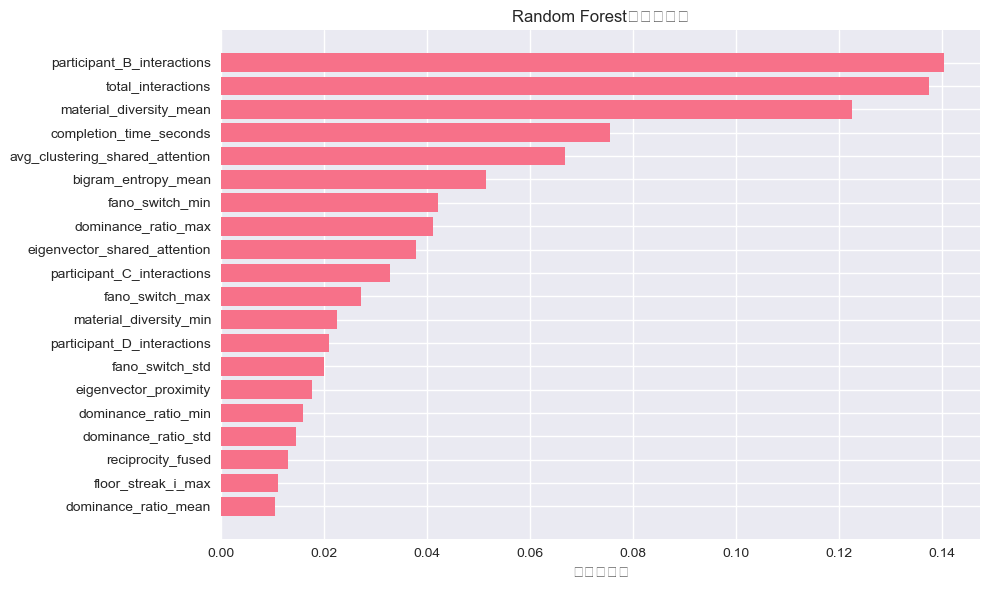

In [3]:
# 使用Random Forest计算特征重要性
print("训练Random Forest分类器...")
rf = RandomForestClassifier(
    n_estimators=config.SUPERVISED_CONFIG['rf_n_estimators'],
    max_depth=config.SUPERVISED_CONFIG['rf_max_depth'],
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 提取特征重要性
rf_importance = dict(zip(top_k_features, rf.feature_importances_))
rf_sorted = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\n前20个特征的重要性:")
top_rf_df = pd.DataFrame(rf_sorted[:20], columns=['feature', 'importance'])
display(top_rf_df)

# 可视化
plot_feature_importance(
    [score for _, score in rf_sorted],
    [feat for feat, _ in rf_sorted],
    top_n=20,
    title="Random Forest特征重要性",
    save_path=config.VISUALIZATIONS_DIR / 'feature_importance_rf.png'
)


## 3. 互信息分析


In [4]:
# 计算特征与Y标签的互信息
print("计算互信息...")
mi_scores = mutual_info_classif(
    X_train,
    y_train,
    random_state=config.RANDOM_STATE
)

mi_importance = dict(zip(top_k_features, mi_scores))
mi_sorted = sorted(mi_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\n前20个特征的互信息分数:")
top_mi_df = pd.DataFrame(mi_sorted[:20], columns=['feature', 'mutual_info'])
display(top_mi_df)


计算互信息...

前20个特征的互信息分数:


,feature,mutual_info
0,bigram_entropy_mean,0.1354
1,fano_switch_max,0.1353
2,dominance_ratio_std,0.1352
3,material_diversity_min,0.1352
4,fano_switch_min,0.1344
5,dominance_ratio_max,0.1343
6,dominance_ratio_min,0.1335
7,participant_C_interactions,0.1333
8,participant_D_interactions,0.1330
9,material_diversity_mean,0.1327


## 4. 递归特征消除（RFE）


In [5]:
# 使用RFE选择特征
print("执行递归特征消除...")
n_features_to_select = config.SUPERVISED_CONFIG['top_m'] if config.SUPERVISED_CONFIG['top_m'] <= len(top_k_features) else len(top_k_features)

rfe = RFE(
    estimator=RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        random_state=config.RANDOM_STATE,
        n_jobs=-1
    ),
    n_features_to_select=n_features_to_select,
    step=1
)
rfe.fit(X_train, y_train)

# RFE评分（被选中的特征得分为1，未选中的为0）
rfe_scores = dict(zip(top_k_features, rfe.ranking_))
# 将ranking转换为分数（ranking越小越好，转换为分数越大越好）
rfe_importance = {feat: 1.0 / rank for feat, rank in rfe_scores.items()}
rfe_sorted = sorted(rfe_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\nRFE选择了{n_features_to_select}个特征")
print(f"前20个特征的RFE分数:")
top_rfe_df = pd.DataFrame(rfe_sorted[:20], columns=['feature', 'rfe_score'])
display(top_rfe_df)


执行递归特征消除...

RFE选择了30个特征
前20个特征的RFE分数:


,feature,rfe_score
0,dominance_ratio_std,1.0
1,bigram_entropy_mean,1.0
2,eigenvector_conversation,1.0
3,material_diversity_min,1.0
4,material_diversity_mean,1.0
5,participant_D_interactions,1.0
6,dominance_ratio_max,1.0
7,total_interactions,1.0
8,participant_B_interactions,1.0
9,fano_switch_std,1.0


## 5. LASSO正则化


In [6]:
# 使用LASSO选择特征
print("训练LASSO分类器...")
import time
start_time = time.time()

lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0 / config.SUPERVISED_CONFIG['lasso_alpha'],
    random_state=config.RANDOM_STATE,
    max_iter=300,  # 减少迭代次数（通常200-300次足够）
    tol=1e-3,  # 放宽收敛阈值，加快训练
    verbose=1  # 显示训练进度
)
lasso.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"✓ LASSO训练完成，耗时: {elapsed_time:.2f}秒")

# 提取系数绝对值作为重要性
lasso_importance = dict(zip(top_k_features, np.abs(lasso.coef_[0])))
lasso_sorted = sorted(lasso_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\n前20个特征的LASSO系数:")
top_lasso_df = pd.DataFrame(lasso_sorted[:20], columns=['feature', 'lasso_coef'])
display(top_lasso_df)

# 统计非零系数（被选中的特征）
selected_by_lasso = [feat for feat, coef in lasso_importance.items() if coef > 1e-6]
print(f"\nLASSO选择了{len(selected_by_lasso)}个特征（非零系数）")


训练LASSO分类器...
[LibLinear]✓ LASSO训练完成，耗时: 31.06秒

前20个特征的LASSO系数:


,feature,lasso_coef
0,density_conversation,49.2033
1,eigenvector_conversation,27.7138
2,avg_clustering_conversation,15.6816
3,material_diversity_std,15.3141
4,completion_time_seconds,13.4839
5,reciprocity_fused,8.8231
6,participant_C_interactions,8.7693
7,avg_clustering_shared_attention,8.7578
8,fano_switch_std,8.4993
9,participant_B_interactions,8.4389



LASSO选择了48个特征（非零系数）


## 6. SHAP值分析（可选，计算较慢）


In [8]:
# 使用SHAP计算特征重要性（使用较小的样本集以加快计算）
print("计算SHAP值（使用样本集）...")
sample_size = min(100, len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]

# 使用TreeExplainer（适用于树模型）
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# 对于二分类，取正类的SHAP值
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # 正类的SHAP值

# 确保shap_values是numpy数组
shap_values = np.array(shap_values)

# 计算平均绝对SHAP值作为重要性
# 如果shap_values是2D数组 (n_samples, n_features)，则mean(axis=0)得到1D数组
# 如果shap_values是1D数组，则直接使用
if shap_values.ndim > 1:
    shap_importance_scores = np.abs(shap_values).mean(axis=0)
else:
    shap_importance_scores = np.abs(shap_values)

# 确保shap_importance_scores是一维数组，且长度与特征数匹配
if shap_importance_scores.ndim > 1:
    shap_importance_scores = shap_importance_scores.flatten()

# 如果长度不匹配，可能需要调整
if len(shap_importance_scores) != len(top_k_features):
    print(f"警告: SHAP值数量({len(shap_importance_scores)})与特征数量({len(top_k_features)})不匹配")
    # 如果SHAP值数量少于特征数，只使用前N个特征
    min_len = min(len(shap_importance_scores), len(top_k_features))
    shap_importance = dict(zip(top_k_features[:min_len], shap_importance_scores[:min_len]))
    # 对于没有SHAP值的特征，设置为0
    for feat in top_k_features[min_len:]:
        shap_importance[feat] = 0.0
else:
    shap_importance = dict(zip(top_k_features, shap_importance_scores))

# 排序（确保值是标量）
shap_sorted = sorted(shap_importance.items(), key=lambda x: float(x[1]), reverse=True)

print(f"\n前20个特征的平均绝对SHAP值:")
top_shap_df = pd.DataFrame(shap_sorted[:20], columns=['feature', 'shap_value'])
display(top_shap_df)


计算SHAP值（使用样本集）...
警告: SHAP值数量(100)与特征数量(50)不匹配

前20个特征的平均绝对SHAP值:


,feature,shap_value
0,material_diversity_std,0.0118
1,silence_max,0.0118
2,reciprocity_fused,0.0093
3,fano_switch_min,0.0093
4,participant_B_interactions,0.0068
5,fano_switch_std,0.0068
6,joint_att_count_min,0.0060
7,floor_streak_i_mean,0.0060
8,participant_C_interactions,0.0050
9,reciprocity_conversation,0.0050


## 7. 综合评分和特征选择


In [9]:
# 归一化各方法的分数
def normalize_scores(scores_dict):
    """将分数归一化到[0, 1]"""
    scores_array = np.array(list(scores_dict.values()))
    if scores_array.max() > scores_array.min():
        normalized = (scores_array - scores_array.min()) / (scores_array.max() - scores_array.min())
    else:
        normalized = np.ones_like(scores_array)
    return dict(zip(scores_dict.keys(), normalized))

# 归一化
rf_norm = normalize_scores(rf_importance)
mi_norm = normalize_scores(mi_importance)
rfe_norm = normalize_scores(rfe_importance)
lasso_norm = normalize_scores(lasso_importance)
shap_norm = normalize_scores(shap_importance)

# 综合评分（加权平均）
weights = {
    'rf': 0.3,
    'mi': 0.2,
    'rfe': 0.2,
    'lasso': 0.15,
    'shap': 0.15
}

combined_scores = {}
for feature in top_k_features:
    combined_scores[feature] = (
        weights['rf'] * rf_norm[feature] +
        weights['mi'] * mi_norm[feature] +
        weights['rfe'] * rfe_norm[feature] +
        weights['lasso'] * lasso_norm[feature] +
        weights['shap'] * shap_norm[feature]
    )

# 按综合分数排序
sorted_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

print(f"综合评分完成，共{len(sorted_features)}个特征")
print(f"\n前20个特征的综合分数:")
top_features_df = pd.DataFrame(sorted_features[:20], columns=['feature', 'combined_score'])
display(top_features_df)

# 选择Top-M特征
top_m = config.SUPERVISED_CONFIG['top_m']
top_m_features = [feat for feat, _ in sorted_features[:top_m]]

print(f"\n选择的Top-{top_m}特征:")
print(top_m_features)


综合评分完成，共50个特征

前20个特征的综合分数:


,feature,combined_score
0,participant_B_interactions,0.8061
1,total_interactions,0.7257
2,material_diversity_mean,0.7127
3,completion_time_seconds,0.6232
4,fano_switch_min,0.6216
5,material_diversity_std,0.6071
6,participant_C_interactions,0.5569
7,avg_clustering_shared_attention,0.5526
8,fano_switch_std,0.5500
9,reciprocity_fused,0.5400



选择的Top-30特征:
['participant_B_interactions', 'total_interactions', 'material_diversity_mean', 'completion_time_seconds', 'fano_switch_min', 'material_diversity_std', 'participant_C_interactions', 'avg_clustering_shared_attention', 'fano_switch_std', 'reciprocity_fused', 'bigram_entropy_mean', 'dominance_ratio_max', 'participant_D_interactions', 'material_diversity_min', 'density_conversation', 'fano_switch_max', 'dominance_ratio_min', 'eigenvector_conversation', 'eigenvector_shared_attention', 'participant_A_interactions', 'eigenvector_proximity', 'dominance_ratio_mean', 'material_diversity_max', 'dominance_ratio_std', 'floor_streak_i_mean', 'speak_only_i_max', 'floor_streak_i_max', 'speak_only_j_mean', 'floor_streak_j_max', 'burst_overlap_rate_mean']


## 8. 验证特征选择效果


In [10]:
# 在训练验证集上验证特征选择效果
train_val_data = load_intermediate('train_val_data')
y_train_val = load_intermediate('y_train_val')

X_train_val = train_val_data[top_k_features].copy()
X_train_val_selected = train_val_data[top_m_features].copy()

# 使用Top-K特征训练模型
rf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)
rf_full.fit(X_train, y_train)

# 使用Top-M特征训练模型
rf_selected = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)
rf_selected.fit(X_train[top_m_features], y_train)

# 评估性能
y_pred_full = rf_full.predict(X_train_val)
y_pred_selected = rf_selected.predict(X_train_val_selected)

f1_full = f1_score(y_train_val, y_pred_full, zero_division=0)
f1_selected = f1_score(y_train_val, y_pred_selected, zero_division=0)

print(f"训练验证集性能对比:")
print(f"  Top-K特征 ({len(top_k_features)}个): F1 = {f1_full:.4f}")
print(f"  Top-M特征 ({len(top_m_features)}个): F1 = {f1_selected:.4f}")
print(f"  性能变化: {f1_selected - f1_full:.4f} ({'提升' if f1_selected > f1_full else '下降'})")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_val_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train_val.pkl
训练验证集性能对比:
  Top-K特征 (50个): F1 = 0.6067
  Top-M特征 (30个): F1 = 0.6067
  性能变化: 0.0000 (下降)


## 9. 保存结果


已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_m_features.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\supervised_feature_scores.pkl
✓ 结果已保存


C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\utils\visualization_utils.py:47: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\Downloads\Share

已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations\feature_importance_supervised.png


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32456 (\N{CJK UNIFIED IDEOGRAPH-7EC8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36873 (\N{CJK UNIFIED IDEOGRAPH-9009}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25321 (\N{CJK UNIFIED IDEOGRAPH-62E9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabto

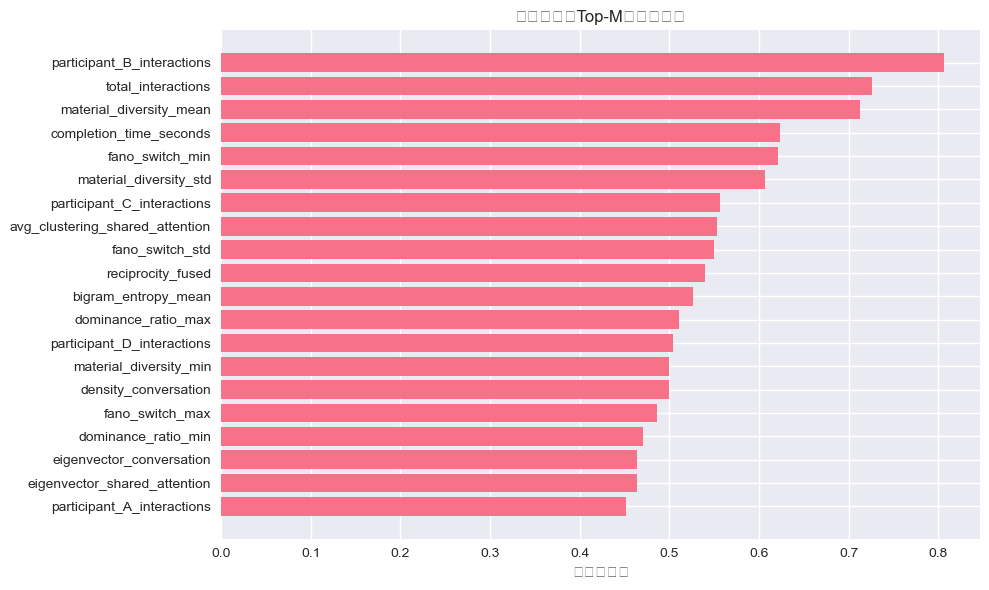

In [11]:
# 保存最终选择的特征
save_intermediate('top_m_features', top_m_features)

# 保存所有评分结果
supervised_scores = {
    'rf_importance': rf_importance,
    'mi_importance': mi_importance,
    'rfe_importance': rfe_importance,
    'lasso_importance': lasso_importance,
    'shap_importance': shap_importance,
    'combined_scores': combined_scores,
    'top_m_features': top_m_features,
    'validation_f1_full': f1_full,
    'validation_f1_selected': f1_selected,
}
save_intermediate('supervised_feature_scores', supervised_scores)

print("✓ 结果已保存")

# 可视化最终特征重要性
plot_feature_importance(
    [combined_scores[feat] for feat in top_m_features],
    top_m_features,
    top_n=min(20, len(top_m_features)),
    title="最终选择的Top-M特征重要性",
    save_path=config.VISUALIZATIONS_DIR / 'feature_importance_supervised.png'
)


## 10. 生成报告


In [12]:
# 生成有监督特征选择报告
report_path = config.REPORTS_DIR / 'feature_selection_supervised_report.txt'

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=== 有监督特征重要性分析报告 ===\n\n")
    
    f.write("1. 输入信息\n")
    f.write(f"   Top-K特征数: {len(top_k_features)}\n")
    f.write(f"   最终选择的Top-M特征数: {len(top_m_features)}\n")
    f.write(f"   训练集样本数: {len(X_train)}\n")
    f.write(f"   Y标签分布: {pd.Series(y_train).value_counts().to_dict()}\n")
    
    f.write("\n2. 各方法特征重要性（前10个）\n")
    f.write("   Random Forest:\n")
    for feat, score in rf_sorted[:10]:
        f.write(f"     {feat}: {score:.4f}\n")
    f.write("   互信息:\n")
    for feat, score in mi_sorted[:10]:
        f.write(f"     {feat}: {score:.4f}\n")
    f.write("   RFE:\n")
    for feat, score in rfe_sorted[:10]:
        f.write(f"     {feat}: {score:.4f}\n")
    f.write("   LASSO:\n")
    for feat, score in lasso_sorted[:10]:
        f.write(f"     {feat}: {score:.4f}\n")
    f.write("   SHAP:\n")
    for feat, score in shap_sorted[:10]:
        f.write(f"     {feat}: {score:.4f}\n")
    
    f.write("\n3. 最终选择的Top-M特征\n")
    for i, feat in enumerate(top_m_features, 1):
        f.write(f"   {i}. {feat} (综合分数: {combined_scores[feat]:.4f})\n")
    
    f.write("\n4. 验证集性能对比\n")
    f.write(f"   Top-K特征 F1分数: {f1_full:.4f}\n")
    f.write(f"   Top-M特征 F1分数: {f1_selected:.4f}\n")
    f.write(f"   性能变化: {f1_selected - f1_full:.4f}\n")

print(f"已生成报告: {report_path}")


已生成报告: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports\feature_selection_supervised_report.txt
